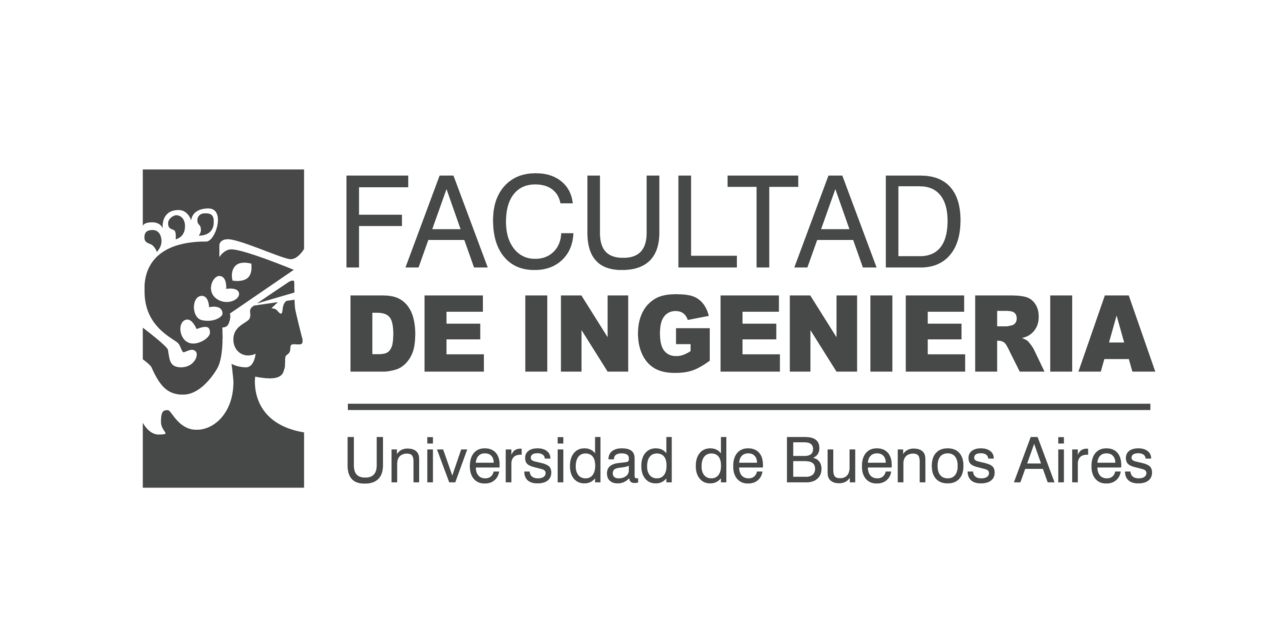

## Aprendizaje Profundo - TP1
### Cohorte 18 - 1er bimestre 2025

**Profesores:** <br />
Dr. Ing. Marcos Maillot - marcos_maillot@yahoo.com.ar <br />
Dr. Antonio Zarauz - hedrergudene@gmail.com <br />
Mg. Ing. Gerardo Vilcamiza - gerardox2000@gmail.com <br />

**Alumnos:** <br />
Mg. Ing. Joaquin Gonzalez - joagonzalez@gmail.com <br />

**Repositorio Github**<br />
https://github.com/joagonzalez/ceia-aprendizaje-profundo <br />

## Consigna

Este primer TP comienza desde el día después de la clase 2 (12 de marzo) y la ventana de entrega estará abierta hasta las **23hs del lunes 7 de abril (hora de Argentina)**. La resolución del TP es **individual**. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citadas incluyendo el correspondiente link o página de libro.

El formato de entrega debe ser un link a un notebook de google colab (permitir acceso a gerardo.vilcamiza@ieee.org y gvilcamiza.ext@fi.uba.ar) y **se realizará en el siguiente link de google forms: [link](https://forms.gle/ViVSD2CG8TcrZ9wBA)**. Tanto los resultados, como el código y las explicaciones deben quedar guardados y visualizables en el colab.

NO ES NECESARIO QUE NOS ENVIEN COREEO AVISANDO DE LA ENTREGA.

**Consideraciones a tener en cuenta:**
- Se entregará 1 solo colab para este TP1.
- Renombrar el archivo de la siguiente manera: **APELLIDO-NOMBRE-DL-TP1-Co18.ipynb**
- Los códigos deben poder ejecutarse.
- Los resultados, cómo el código, los gráficos y las explicaciones deben quedar guardados y visualizables en el correspondiente notebook.
- Prestar atención a las consignas, responder las preguntas cuando corresponda.

## **PREGUNTA 1**

### Teoria

#### **Comparación de Gradiente Descendente y Adam en una Función de Costo No Convexa**

En este ejercicio se compararán los optimizadores Gradiente Descendente (GD) y Adam en la minimización de una función de costo basada en una red neuronal de una sola neurona:
$$
z = w x + b
$$
Con activación tangente hiperbólica:

$$
\hat{y} = \tanh(z) = \tanh(w x + b)
$$

Se analizará la trayectoria de aprendizaje de ambos algoritmos y se evaluará su eficiencia con diferentes tasas de aprendizaje (learning rate).


La función de costo utilizada es el Error Cuadrático Medio (MSE):

$$
J(w, b) = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}_i - y_i)^2
$$

$$
J(w, b) = \frac{1}{m} \sum_{i=1}^{m} ( \tanh(w x_i + b) - y_i )^2
$$

donde $w$ y $b$ son los parámetros a optimizar.


Si bien es cierto, en estos experimentos estamos comparando optimizadores (GD vs Adam), y no entrenando un modelo como tal, de igual forma se necesitará una especie de dataset. Este será sintético y solo de prueba, por ende tendrán cierta libertad para elegir sus valores. Sin embargo deberán tomar en cuenta que cumpla la siguiente estructura:

x = np.linspace(ini, fin, n)

donde $x$ es un array de una sola dimensión y con $n$ cantidad de valores. Y tiene un rango de valores desde $ini$ hasta $fin$. Recomiendo que sean los mismos valores solo que con el signo cambiado, por ejemplo $ini=-3 , fin=3$.


Y con un target $y$:

$y = \text{función\_no\_lineal}(x) + \text{ruido}$

donde $y$ es también un vector de una sola dimensión de tamaño $n$ que sigue un patrón no lineal con respecto a `x` adicionando un ruido que puede ser creado con algunas de las funciones del paquete $np.random$.


### Dependencias y Clases base

In [2]:
%pip install numpy
%pip install matplotlib
%pip install pandas
%pip install seaborn
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

#### Derivación del gradiente con la regla de la cadena

Queremos calcular los gradientes de la función de costo respecto a los parámetros \( w \) y \( b \). Usamos la **regla de la cadena**:

$$
\frac{\partial J}{\partial w} = \frac{\partial J}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial z} \cdot \frac{\partial z}{\partial w}
$$

Donde:

$$
\frac{\partial z}{\partial w} = x
$$

$$
\frac{\partial \hat{y}}{\partial z} = 1 - \tanh^2(z)
$$

$$
\frac{\partial J}{\partial \hat{y}} = 2(\hat{y} - y)
$$

Entonces:

$$
\frac{\partial J}{\partial w} = 2(\hat{y} - y) \cdot (1 - \tanh^2(z)) \cdot x
$$

Y de forma análoga, para el sesgo:

$$
\frac{\partial J}{\partial b} = 2(\hat{y} - y) \cdot (1 - \tanh^2(z))
$$

In [4]:
import numpy as np

class SingleNeuron:
    """Clase para una única neurona. Version vectorizada, se pasa el dataset completo."""
    def __init__(self):
        self.w = np.random.randn()
        self.b = np.random.randn()

    def activation(self, z):
        """Función de activación: tanh."""
        return np.tanh(z)

    def activation_derivative(self, z):
        """Derivada de tanh."""
        return 1 - np.tanh(z) ** 2

    def forward(self, x):
        """Propagación hacia adelante."""
        z = self.w * x + self.b
        return self.activation(z)

    def compute_loss(self, y_hat, y):
        """Cálculo del error cuadrático medio."""
        return np.mean((y_hat - y) ** 2)

    def backward(self, x, y):
        """Cálculo de gradientes de w y b."""
        m = len(x)
        z = self.w * x + self.b
        y_hat = self.activation(z)

        dz = 2 * (y_hat - y) * self.activation_derivative(z)
        # Se devuelven valores medios de los gradientes
        dw = np.mean(dz * x)
        db = np.mean(dz)
        return dw, db

In [5]:
from abc import ABC, abstractmethod

class Optimizer: 
    class Optimizer(ABC):
        @abstractmethod
        def __init__(self, *args, **kwargs):
            pass

        @abstractmethod
        def step(self, neuron: SingleNeuron, dw: float, db: float):
            pass

In [6]:
class GradientDescentOptimizer(Optimizer):
    """Optimizador por descenso de gradiente."""
    def __init__(self, lr=0.01):
        self.lr = lr

    def step(self, neuron: SingleNeuron, dw: float, db: float):
        neuron.w -= self.lr * dw
        neuron.b -= self.lr * db

In [7]:
class AdamOptimizer(Optimizer):
    """Optimizador Adam."""
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m_w = 0
        self.v_w = 0
        self.m_b = 0
        self.v_b = 0
        self.t = 0

    def step(self, neuron: SingleNeuron, dw: float, db: float):
        self.t += 1

        self.m_w = self.beta1 * self.m_w + (1 - self.beta1) * dw
        self.v_w = self.beta2 * self.v_w + (1 - self.beta2) * (dw ** 2)
        self.m_b = self.beta1 * self.m_b + (1 - self.beta1) * db
        self.v_b = self.beta2 * self.v_b + (1 - self.beta2) * (db ** 2)

        m_w_corr = self.m_w / (1 - self.beta1 ** self.t)
        v_w_corr = self.v_w / (1 - self.beta2 ** self.t)
        m_b_corr = self.m_b / (1 - self.beta1 ** self.t)
        v_b_corr = self.v_b / (1 - self.beta2 ** self.t)

        neuron.w -= self.lr * m_w_corr / (np.sqrt(v_w_corr) + self.epsilon)
        neuron.b -= self.lr * m_b_corr / (np.sqrt(v_b_corr) + self.epsilon)

In [8]:
def generate_dataset(n: int = 10000, ini: int = -3, fin: int = 3, noise_std: float = 0.1):
    x = np.linspace(ini, fin, n)
    y = np.tanh(x) + np.random.normal(0, noise_std, size=x.shape)
    return x, y

In [9]:
def train(neuron: SingleNeuron, optimizer: Optimizer, x, y, epochs=100, verbose=True):
    """
    Entrenamiento de la neurona, se entrena con el dataset completo en cada epoca ya que x, y son vectores.
    """
    # Inicializar lista de pérdidas
    losses = []

    for epoch in range(epochs):
        # Pasada forward
        y_hat = neuron.forward(x)

        # Computar perdida
        loss = neuron.compute_loss(y_hat, y)
        losses.append(loss)

        # Pasada backward
        dw, db = neuron.backward(x, y)

        # Actualizar pesos de la red
        optimizer.step(neuron, dw, db)

        if verbose and (epoch % 10 == 0 or epoch == epochs - 1):
            print(f"Epoch {epoch:3d} | Loss: {loss:.6f} | w: {neuron.w:.4f} | b: {neuron.b:.4f}")

    return losses

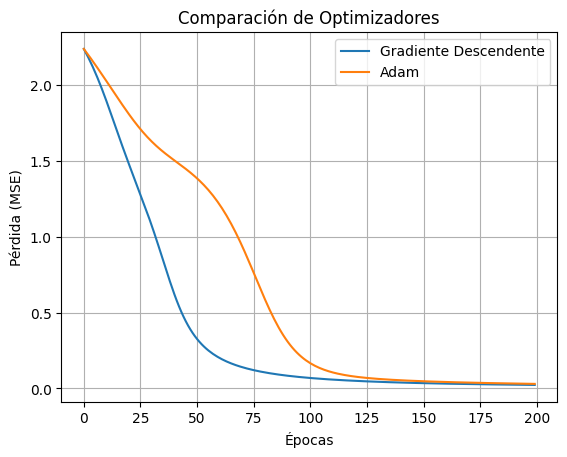

In [10]:
# Generar dataset
x, y = generate_dataset(n=100, ini=-3, fin=3, noise_std=0.1)

# Inicializar neuronas independientes para comparar
neuron_gd = SingleNeuron()
neuron_adam = SingleNeuron()

# Copiar los mismos pesos iniciales para comparación justa
neuron_adam.w = neuron_gd.w
neuron_adam.b = neuron_gd.b

# Optimizadores
gd = GradientDescentOptimizer(lr=0.01)
adam = AdamOptimizer(lr=0.01)

# Entrenar
losses_gd = train(neuron_gd, gd, x, y, epochs=200, verbose=False)
losses_adam = train(neuron_adam, adam, x, y, epochs=200, verbose=False)

# Graficar comparación
plt.plot(losses_gd, label="Gradiente Descendente")
plt.plot(losses_adam, label="Adam")
plt.xlabel("Épocas")
plt.ylabel("Pérdida (MSE)")
plt.title("Comparación de Optimizadores")
plt.legend()
plt.grid(True)
plt.show()

### 1a) Implementación del Gradiente Descendente (1 punto)

#### Consigna

- Implementar el algoritmo del Gradiente Descendente (GD) para minimizar ($J(w, b)$).
- Utilizar 100 épocas y 3 diferentes learning rates `(0.1, 0.01, 0.001)`.
- Inicializar valores de ($w$) y ($b$) de manera aleatoria con `np.random.randn()` para cada learning rate.
- Graficar la función de Costo ($J(w, b)$) VS número de época

El optimizador del Gradiente Descendente se debe implementar haciendo el código desde cero y paso a paso. Se pueden usar librerías como `numpy`, `scipy`, `matplotlib` o similares. Pero no está permitido usar Pytorch ni TensorFlow o frameworks que ya contengan el optimizador desarrollado.

#### Desarrollo

Epoch   0 | Loss: 1.449727 | w: 0.0825 | b: -1.3728
Epoch  10 | Loss: 0.172482 | w: 0.9067 | b: -0.7572
Epoch  20 | Loss: 0.062597 | w: 1.0429 | b: -0.4872
Epoch  30 | Loss: 0.032364 | w: 1.0829 | b: -0.3266
Epoch  40 | Loss: 0.020281 | w: 1.0932 | b: -0.2214
Epoch  50 | Loss: 0.014890 | w: 1.0918 | b: -0.1506
Epoch  60 | Loss: 0.012376 | w: 1.0856 | b: -0.1025
Epoch  70 | Loss: 0.011176 | w: 1.0778 | b: -0.0699
Epoch  80 | Loss: 0.010588 | w: 1.0697 | b: -0.0479
Epoch  90 | Loss: 0.010291 | w: 1.0619 | b: -0.0331
Epoch  99 | Loss: 0.010145 | w: 1.0554 | b: -0.0240
Epoch   0 | Loss: 0.248996 | w: 0.7804 | b: -0.8798
Epoch  10 | Loss: 0.209507 | w: 0.8210 | b: -0.8329
Epoch  20 | Loss: 0.179922 | w: 0.8542 | b: -0.7906
Epoch  30 | Loss: 0.156855 | w: 0.8820 | b: -0.7520
Epoch  40 | Loss: 0.138329 | w: 0.9055 | b: -0.7164
Epoch  50 | Loss: 0.123113 | w: 0.9257 | b: -0.6833
Epoch  60 | Loss: 0.110392 | w: 0.9432 | b: -0.6525
Epoch  70 | Loss: 0.099606 | w: 0.9585 | b: -0.6237
Epoch  80 | 

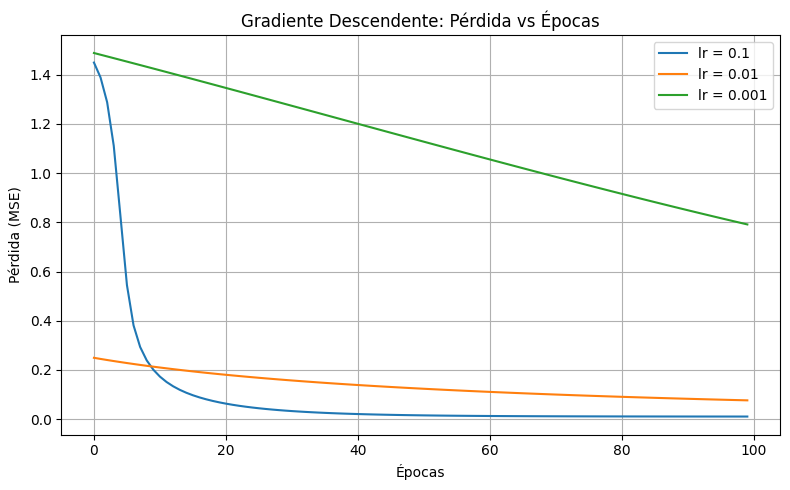

In [73]:
# Dataset sintético
x, y = generate_dataset(n=10000, ini=-3, fin=3, noise_std=0.1)

# Learning rates a probar
learning_rates = [0.1, 0.01, 0.001]
loss_histories = []

for lr in learning_rates:
    # Inicializar neurona con w y b aleatorios
    neuron = SingleNeuron()  # Esto genera nuevos w y b
    optimizer = GradientDescentOptimizer(lr=lr)

    # Entrenar 100 épocas
    losses = train(neuron, optimizer, x, y, epochs=100, verbose=True)

    loss_histories.append((lr, losses))

# Graficar resultados
plt.figure(figsize=(8, 5))

for lr, losses in loss_histories:
    plt.plot(losses, label=f"lr = {lr}")

plt.xlabel("Épocas")
plt.ylabel("Pérdida (MSE)")
plt.title("Gradiente Descendente: Pérdida vs Épocas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 1b) Implementación de Adam (1.5 puntos)

#### Consigna

- Implementar el algoritmo de Adam para minimizar ($J(w, b)$).  
- Utilizar 100 épocas y 3 diferentes learning rates `(0.1, 0.01, 0.001)`.
- Utilizar los mismos valores de ($w$) y ($b$) que se usaron para GD para cada diferente learning rate.
- Graficar la función de Costo ($J(w, b)$) VS número de época
- Comparar el resultado y rendimiento de Adam VS GD para cada learning rate.

Al igual que para GD, el optimizador Adam también se debe implementar desde cero y paso a paso. Se pueden usar librerías como `numpy`, `scipy`, `matplotlib` o similares. Pero no está permitido usar Pytorch ni TensorFlow o frameworks que ya contengan el optimizador desarrollado.

#### Desarrollo


 Comparando GD vs Adam con learning rate = 0.1


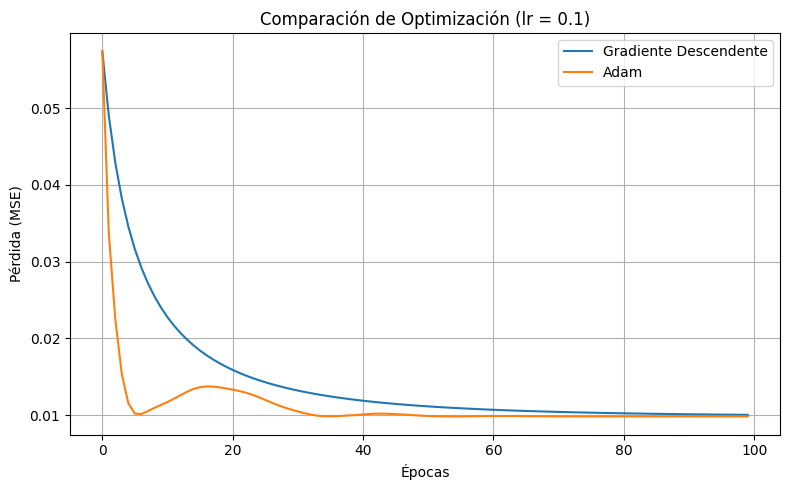


 Comparando GD vs Adam con learning rate = 0.01


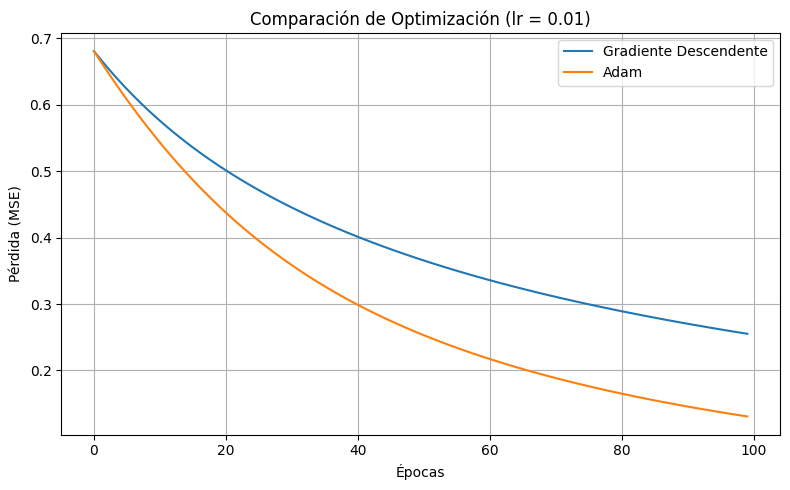


 Comparando GD vs Adam con learning rate = 0.001


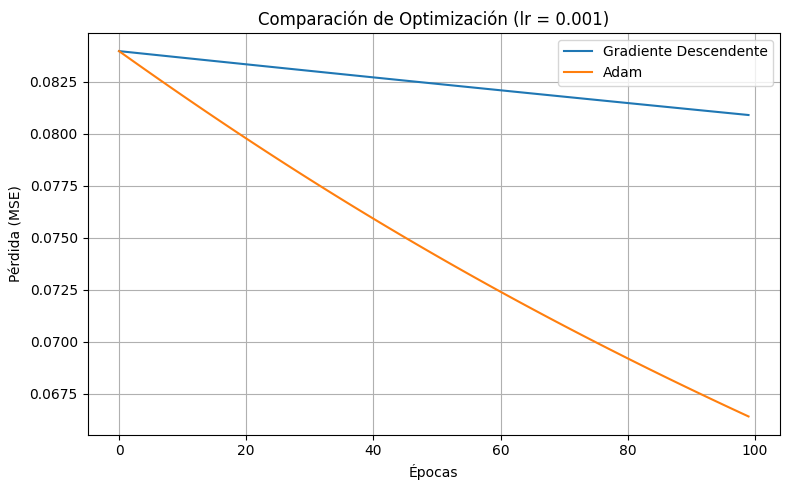

In [79]:
learning_rates = [0.1, 0.01, 0.001]

for lr in learning_rates:
    print(f"\n Comparando GD vs Adam con learning rate = {lr}")

    # Inicializar neurona y guardar pesos
    neuron_gd = SingleNeuron()
    w_init = neuron_gd.w
    b_init = neuron_gd.b

    # Entrenar con GD
    optimizer_gd = GradientDescentOptimizer(lr=lr)
    losses_gd = train(neuron_gd, optimizer_gd, x, y, epochs=100, verbose=False)

    # Inicializar neurona Adam con mismos pesos
    neuron_adam = SingleNeuron()
    neuron_adam.w = w_init
    neuron_adam.b = b_init

    # Entrenar con Adam
    optimizer_adam = AdamOptimizer(lr=lr)
    losses_adam = train(neuron_adam, optimizer_adam, x, y, epochs=100, verbose=False)

    # Graficar comparación
    plt.figure(figsize=(8, 5))
    plt.plot(losses_gd, label="Gradiente Descendente")
    plt.plot(losses_adam, label="Adam")
    plt.title(f"Comparación de Optimización (lr = {lr})")
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida (MSE)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### 1c) Visualización en 3D de la trayectoria de aprendizaje (0.5 puntos)

#### Consigna

- Graficar en 3D la trayectoria del aprendizaje de ambos optimizadores sobre la superficie de la función de costo ($J(w, b)$). Se debe elegir un solo learning rate.
- Comparar cómo se mueven en el espacio de parámetros y qué diferencias existen en la convergencia.
- Recomiendo utilizar `mpl_toolkits.mplot3d` y `np.meshgrid`, pero queda a su criterio la elección de funciones a usar para lograr el gráfico.

#### Desarrollo

Buscamos una representación como la siguiente: 

<img src ="trayectorias.png" width="600" />

In [ ]:
def cost_surface(x, y, w_range, b_range, resolution=50):
    # Generar una superficie de costos para visualizar el error cuadrático medio
    W, B = np.meshgrid(
        np.linspace(*w_range, resolution),
        np.linspace(*b_range, resolution)
    )
    J = np.zeros_like(W)

    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            z = W[i, j] * x + B[i, j]
            y_hat = np.tanh(z)
            J[i, j] = np.mean((y_hat - y)**2)

    return W, B, J

In [ ]:
def train_with_trajectory(neuron: SingleNeuron, optimizer: Optimizer, x: np.array, y: np.array, epochs=100):
    """
    Entrenamiento de la neurona, se entrena con el dataset completo en cada epoca ya que x, y son vectores.
    Además, se guarda la trayectoria de los pesos y bias.
    """
    losses = []
    trajectory = []

    for epoch in range(epochs):
        y_hat = neuron.forward(x)
        loss = neuron.compute_loss(y_hat, y)
        losses.append(loss)

        dw, db = neuron.backward(x, y)
        optimizer.step(neuron, dw, db)

        # Guardar la trayectoria de los pesos y bias para cada epoca
        trajectory.append((neuron.w, neuron.b))

    return losses, trajectory

In [39]:
def trajectory_bounds(trajectory_adam: List, trajectory_gd: List):
    """
    Obtener los límites de la trayectoria para graficar.
    """
    w_all = [w for w, _ in trajectory_gd + trajectory_adam]
    b_all = [b for _, b in trajectory_gd + trajectory_adam]

    print(f"Rango de w: {min(w_all):.2f} a {max(w_all):.2f}")
    print(f"Rango de b: {min(b_all):.2f} a {max(b_all):.2f}")
    
    # Agregar márgenes para tener más espacio en el plot
    w_margin = 0.2
    b_margin = 0.2

    # Establecer límites de la trayectoria
    w_range = (min(w_all) - w_margin, max(w_all) + w_margin)
    b_range = (min(b_all) - b_margin, max(b_all) + b_margin)
    
    return w_range, b_range

In [48]:
# Dataset
x, y = generate_dataset(n=100, ini=-3, fin=3, noise_std=0.1)

# Elegimos un learning rate
lr = 0.01

# Inicializar neurona con pesos aleatorios
neuron_gd = SingleNeuron()
w0, b0 = neuron_gd.w, neuron_gd.b

# GD
optimizer_gd = GradientDescentOptimizer(lr=lr)
_, trajectory_gd = train_with_trajectory(neuron_gd, optimizer_gd, x, y, epochs=100)

# Adam con mismos valores iniciales
neuron_adam = SingleNeuron()
neuron_adam.w, neuron_adam.b = w0, b0
optimizer_adam = AdamOptimizer(lr=lr)
_, trajectory_adam = train_with_trajectory(neuron_adam, optimizer_adam, x, y, epochs=100)

# Obtener límites de la trayectoria
w_range, b_range = trajectory_bounds(trajectory_adam, trajectory_gd)

# Superficie de la función de costo
W, B, J = cost_surface(x, y, w_range=w_range, b_range=b_range, resolution=100)

# Separar trayectorias
# es una lista de tuplas (w_i, b_i)) y se genera una lista de cada uno
w_gd, b_gd = zip(*trajectory_gd)
w_adam, b_adam = zip(*trajectory_adam)

Rango de w: -0.26 a 0.64
Rango de b: -0.85 a -0.03


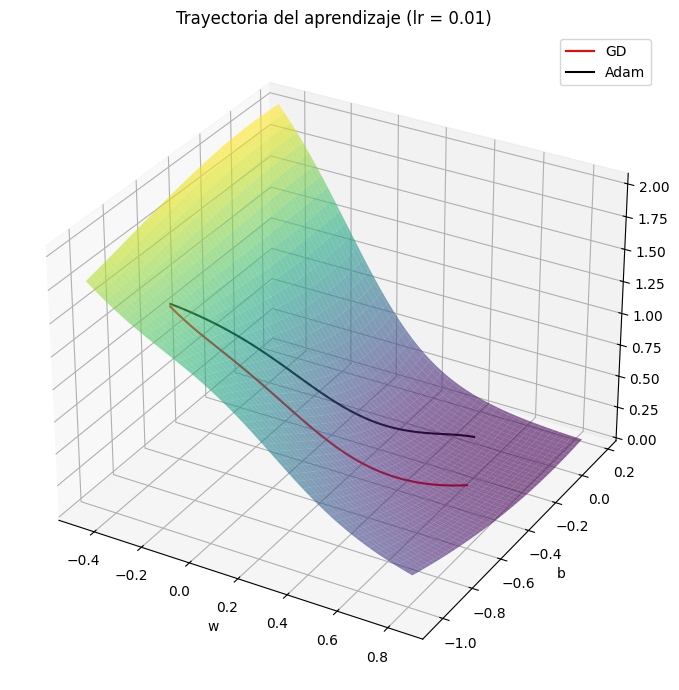

In [49]:
# Graficar en 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(W, B, J, cmap='viridis', alpha=0.6)

# Trayectorias
z_gd = [np.mean((np.tanh(w * x + b) - y)**2) for w, b in trajectory_gd]
z_adam = [np.mean((np.tanh(w * x + b) - y)**2) for w, b in trajectory_adam]

ax.plot(w_gd, b_gd, z_gd, color='red', label='GD')
ax.plot(w_adam, b_adam, z_adam, color='black', label='Adam')

ax.set_xlabel("w")
ax.set_ylabel("b")
ax.set_zlabel("J(w, b)", labelpad=10)

ax.set_title(f"Trayectoria del aprendizaje (lr = {lr})")
ax.legend()

plt.tight_layout()
plt.show()

## **PREGUNTA 2**

Descargar el dataset del siguiente link: https://drive.google.com/file/d/1hiLnMm7ooBj-wJdz0F4vpvjx9DcEgAkg/view?usp=sharing.

El dataset consiste en compras de productos que diferentes clientes realizaron durante un black sales. El dataset contiene información sobre las transacciones y el objetivo es poder utilizarlo para crear diferentes modelos que puedan predecir cuánto un cliente está dispuesto a gastar en un producto en el futuro.


### 2a) EDA y preparación del dataset (2 puntos)

#### Consigna

Realizar el análisis exploratorio del dataset (EDA) con las herramientas vistas en materias anteriores. Pre-procesar las variables, explicar los criterios utilizados y analizar las distribuciones.

Vamos a tratar este problema como una clasificación donde queremos averiguar si el cliente pertenece a una categoría: "Casual" (gasta menos de 5000), "Gama media" (gasta entre 5000 y 10000), "Fiel" (gasta entre 10000 y 15000) o a "Premium" (gasta más de 15000).

#### Desarrollo

In [45]:
df = pd.read_csv('dataset_black_sales.csv')
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [46]:
df[["User_ID", "Product_ID"]].nunique()

User_ID       5891
Product_ID    3631
dtype: int64

Solo se observan NULLs en las categorias 2 y 3. Hay 550k entradas en el dataset y un total de 12 features.

In [47]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

Agregamos variable target para problema de clasificación. Además, interpretamos a los NaN de los product category 2 y 3 como que no se compro nada allí, se los reemplaza con 0.

In [48]:
df["Product_Category_2"].fillna(0, inplace=True)
df["Product_Category_3"].fillna(0, inplace=True)

/tmp/ipykernel_184911/268382419.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Product_Category_2"].fillna(0, inplace=True)
/tmp/ipykernel_184911/268382419.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

In [49]:
def clasificar_cliente(p: int) -> str:
    if p < 5000:
        return "Casual"
    elif p < 10000:
        return "Gama media"
    elif p < 15000:
        return "Fiel"
    else:
        return "Premium"

df["Segmento"] = df["Purchase"].apply(clasificar_cliente)

In [50]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Segmento
0,1000001,P00069042,F,0-17,10,A,2,0,3,0.0,0.0,8370,Gama media
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200,Premium
2,1000001,P00087842,F,0-17,10,A,2,0,12,0.0,0.0,1422,Casual
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,0.0,1057,Casual
4,1000002,P00285442,M,55+,16,C,4+,0,8,0.0,0.0,7969,Gama media


Vemos que la clases Premium Casual y Fiel estan practicamente balanceadas, no es el caso con Gama media. Se corrobora con el histograma por purchases usando los limites de la clase.

<Axes: title={'center': 'Distribución de clases'}, xlabel='Segmento'>

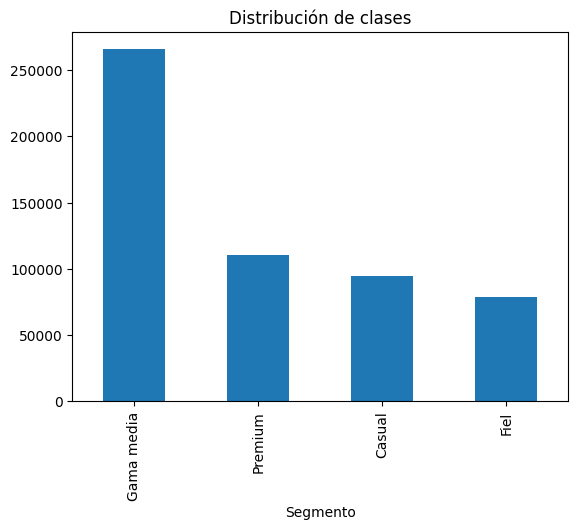

In [51]:
df["Segmento"].value_counts().plot(kind="bar", title="Distribución de clases")

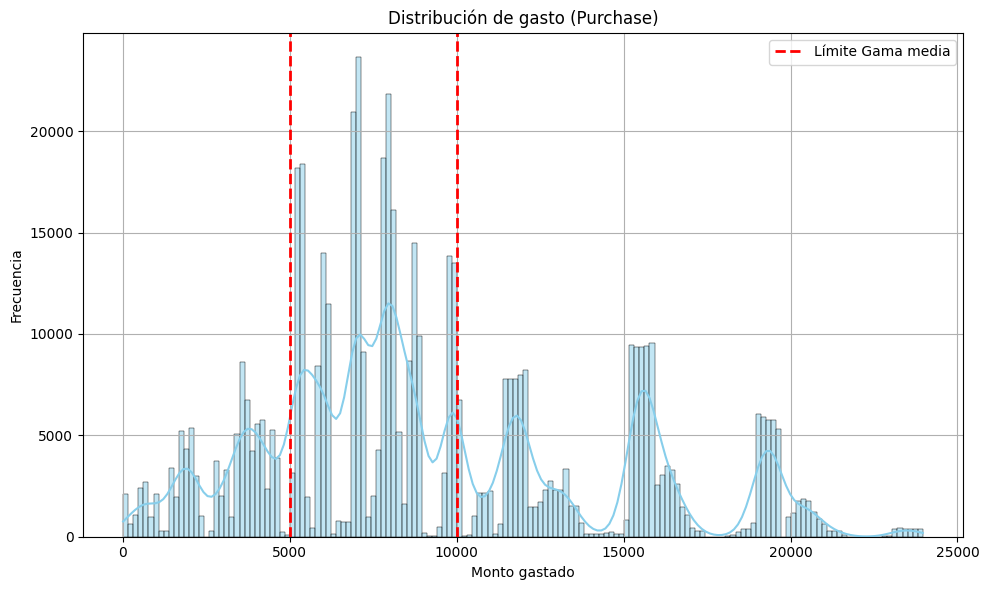

In [52]:
plt.figure(figsize=(10, 6))
sns.histplot(df["Purchase"], kde=True, color="skyblue")

# Líneas rojas en 5000 y 10000
plt.axvline(5000, color="red", linestyle="--", linewidth=2, label="Límite Gama media")
plt.axvline(10000, color="red", linestyle="--", linewidth=2)

plt.title("Distribución de gasto (Purchase)")
plt.xlabel("Monto gastado")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Al hacer cruce entre categoricas y purchase no se ven cambios significativos entre las categorias. Se observa la mayor diferencia en el caso de city category con una media mas alta. Tal vez sean productos que no son tan sensibles a esas categoricas o lo son de manera sutil.

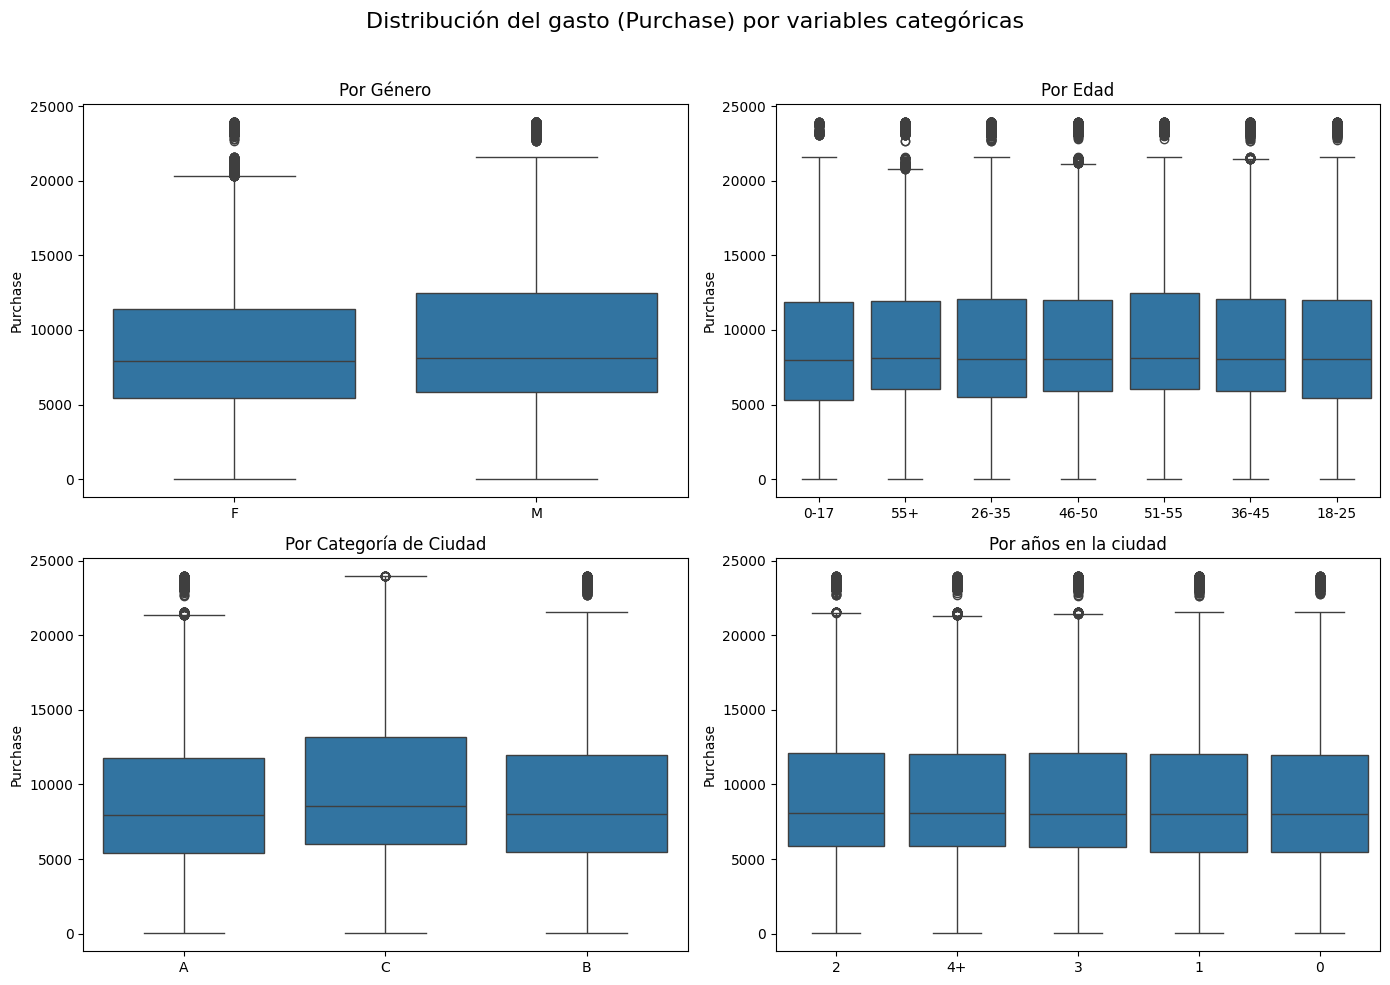

In [53]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Distribución del gasto (Purchase) por variables categóricas", fontsize=16)

# Boxplot por Género
sns.boxplot(x="Gender", y="Purchase", data=df, ax=axs[0, 0])
axs[0, 0].set_title("Por Género")

# Boxplot por Edad
sns.boxplot(x="Age", y="Purchase", data=df, ax=axs[0, 1])
axs[0, 1].set_title("Por Edad")

# Boxplot por Categoría de Ciudad
sns.boxplot(x="City_Category", y="Purchase", data=df, ax=axs[1, 0])
axs[1, 0].set_title("Por Categoría de Ciudad")

# Boxplot por años en la ciudad
sns.boxplot(x="Stay_In_Current_City_Years", y="Purchase", data=df, ax=axs[1, 1])
axs[1, 1].set_title("Por años en la ciudad")

# Ajustar distribución
for ax in axs.flat:
    ax.set_xlabel("")
    ax.set_ylabel("Purchase")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [54]:
# One hot encoding, preparamos para entrenamiento en el punto siguiente
df = pd.get_dummies(df, columns=["Gender", "Age", "City_Category"], drop_first=True)

In [55]:
df.head()

,User_ID,Product_ID,Occupation,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Segmento,Gender_M,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,City_Category_B,City_Category_C
0,1000001,P00069042,10,2,0,3,0.0,0.0,8370,Gama media,False,False,False,False,False,False,False,False,False
1,1000001,P00248942,10,2,0,1,6.0,14.0,15200,Premium,False,False,False,False,False,False,False,False,False
2,1000001,P00087842,10,2,0,12,0.0,0.0,1422,Casual,False,False,False,False,False,False,False,False,False
3,1000001,P00085442,10,2,0,12,14.0,0.0,1057,Casual,False,False,False,False,False,False,False,False,False
4,1000002,P00285442,16,4+,0,8,0.0,0.0,7969,Gama media,True,False,False,False,False,False,True,False,True


Pareciera que de las numericas, categoria 1 y 3 son las que tienen mayor correlación en módulo con purchase

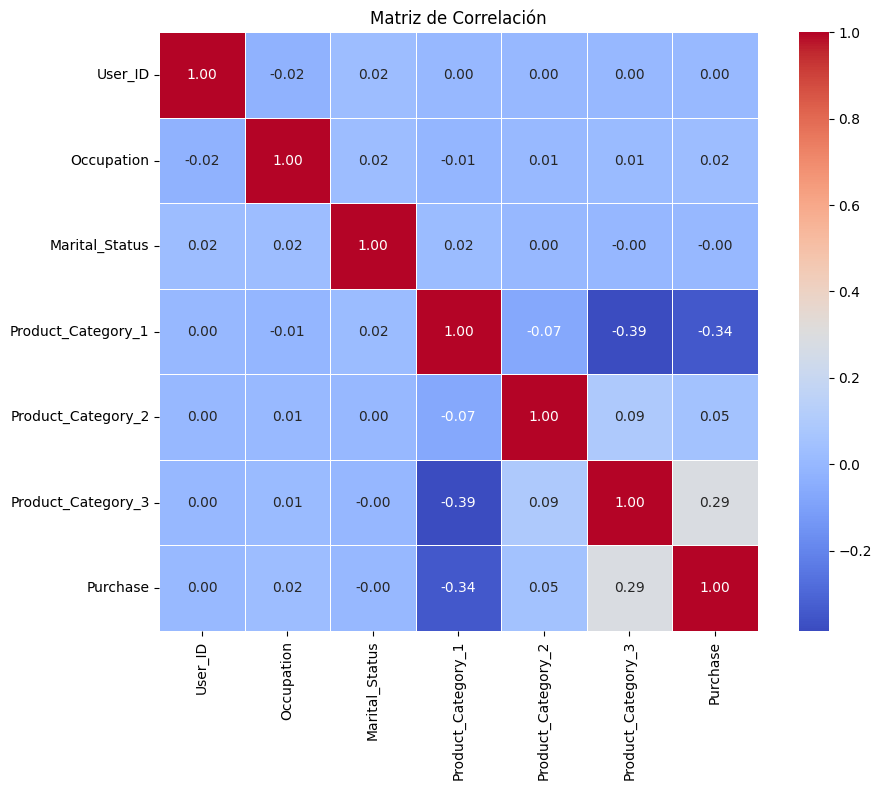

In [56]:
# Calcular la matriz de correlación solo de columnas numéricas
corr_matrix = df.select_dtypes(include=["number"]).corr()

plt.figure(figsize=(10, 8))

# Crear el heatmap
sns.heatmap(corr_matrix,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            linewidths=0.5,
            square=True)

plt.title("Matriz de Correlación")
plt.tight_layout()
plt.show()

User_ID tiene correlacion 0 con purchase, por lo que al ser una categorica de alta cardinalidad sin valor para el target se dropea.

In [43]:
df_filtrado = df[(df["User_ID"] == 1000001)]
df_filtrado.head(2)

,User_ID,Product_ID,Occupation,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Segmento,Gender_M,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,City_Category_B,City_Category_C
0,1000001,P00069042,10,2,0,3,0.0,0.0,8370,Gama media,False,False,False,False,False,False,False,False,False
1,1000001,P00248942,10,2,0,1,6.0,14.0,15200,Premium,False,False,False,False,False,False,False,False,False


Se observa que para un mismo Product_ID los valores de CAT 1|2|3 se repiten, por lo que son subcategorias del mismo Product_ID. Por eso es que no deberia sumar información extra Product_ID y se procede a dropear. Para completar los NaN en vez de reemplazar por 0 podria armarse una heuristica.

In [58]:
df_filtrado = df[(df["Product_ID"] == 'P00248942')]
df_filtrado.head(10)

,User_ID,Product_ID,Occupation,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Segmento,Gender_M,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,City_Category_B,City_Category_C
1,1000001,P00248942,10,2,0,1,6.0,14.0,15200,Premium,False,False,False,False,False,False,False,False,False
126,1000024,P00248942,7,3,1,1,6.0,14.0,15774,Premium,False,False,True,False,False,False,False,False,False
405,1000068,P00248942,4,0,0,1,6.0,14.0,11429,Fiel,True,True,False,False,False,False,False,False,False
516,1000093,P00248942,17,1,1,1,6.0,14.0,11754,Fiel,True,False,True,False,False,False,False,True,False
701,1000135,P00248942,4,1,1,1,6.0,14.0,19146,Premium,True,True,False,False,False,False,False,False,True
757,1000146,P00248942,20,3,1,1,6.0,14.0,15659,Premium,False,False,False,True,False,False,False,True,False
3479,1000560,P00248942,15,1,1,1,6.0,14.0,19409,Premium,True,False,False,False,True,False,False,False,True
4044,1000669,P00248942,17,2,0,1,6.0,14.0,15423,Premium,True,False,True,False,False,False,False,True,False
6479,1001051,P00248942,0,0,1,1,6.0,14.0,19335,Premium,False,False,True,False,False,False,False,False,False
7846,1001220,P00248942,10,3,0,1,6.0,14.0,8285,Gama media,True,False,False,False,False,False,False,False,False


In [59]:
df = df.drop(columns=["User_ID", "Product_ID"])

In [60]:
df.head()

,Occupation,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Segmento,Gender_M,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,City_Category_B,City_Category_C
0,10,2,0,3,0.0,0.0,8370,Gama media,False,False,False,False,False,False,False,False,False
1,10,2,0,1,6.0,14.0,15200,Premium,False,False,False,False,False,False,False,False,False
2,10,2,0,12,0.0,0.0,1422,Casual,False,False,False,False,False,False,False,False,False
3,10,2,0,12,14.0,0.0,1057,Casual,False,False,False,False,False,False,False,False,False
4,16,4+,0,8,0.0,0.0,7969,Gama media,True,False,False,False,False,False,True,False,True


### 2b) Benchmark de modelos de ML clásico  (1 punto)

#### Consigna

Definir uno o varios puntos de comparación (benchmark) para comparar entre sí al menos 2 modelos distintos. Estos deben ser modelos de ML clásico de la librería `sklearn` de fácil y rápido entrenamiento.

#### Desarrollo

Vamos a usar regresión logística multiclase y support vector machines como modelos clásicos para clasificar clases de usuarios por gastos.

In [61]:
le = LabelEncoder()
df["Segmento_encoded"] = le.fit_transform(df["Segmento"])

In [62]:
# Hacemos One hot sobre Stay_In_Current_City_Years ya que tiene 4+ como categoria y la podemos pensar como no numerica
df = pd.get_dummies(df, columns=["Stay_In_Current_City_Years"], drop_first=True)

In [63]:
df.head()

,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Segmento,Gender_M,Age_18-25,Age_26-35,...,Age_46-50,Age_51-55,Age_55+,City_Category_B,City_Category_C,Segmento_encoded,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+
0,10,0,3,0.0,0.0,8370,Gama media,False,False,False,...,False,False,False,False,False,2,False,True,False,False
1,10,0,1,6.0,14.0,15200,Premium,False,False,False,...,False,False,False,False,False,3,False,True,False,False
2,10,0,12,0.0,0.0,1422,Casual,False,False,False,...,False,False,False,False,False,0,False,True,False,False
3,10,0,12,14.0,0.0,1057,Casual,False,False,False,...,False,False,False,False,False,0,False,True,False,False
4,16,0,8,0.0,0.0,7969,Gama media,True,False,False,...,False,False,True,False,True,2,False,False,False,True


In [65]:
X = df.drop(columns=["Purchase", "Segmento", "Segmento_encoded"])
y = df["Segmento_encoded"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [66]:
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
lr.fit(X_train, y_train)



/home/jgonzalez/dev/.virtualenvs/ceia-aprendizaje-profundo/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [ ]:
svm = SVC(kernel='rbf', C=1.0, decision_function_shape='ovr')  # o 'ovo'
svm.fit(X_train, y_train)

### 2c) Modelo de deep leaning sin embeddings (1.5 puntos)

#### Consigna

Entrenar un modelo de deep learning usando Pytorch que no utilice embeddings, **descartando el `product_id` y `user_id`**. Graficar las evoluciones de la función de costo y la metrica de validacion. Explicar el proceso de iteracion utilizado para conseguir los resultados y justificar los resultados obtenidos.

#### Desarrollo

### 2d) Modelo de deep leaning con embeddings (2 puntos)

#### Consigna

Entrenar un modelo de deep learning usando Pytorch que utilice **2 capas de embeddings**, una para los productos y otra para los usuarios. Graficar las evoluciones de la función de costo y la métrica de validación. Explicar el proceso de iteración utilizado para conseguir los resultados y justificar los resultados obtenidos. **Comparar contra el modelo sin embeddings**.
Recordar que tanto para el punto 2c) como el 2d) pueden usarse herramientas como regularización y prueba de hiperpametros para conseguir mejores resultados.

#### Desarrollo

### 2e) Encontrar usuarios similares (0.5 puntos)

#### Consigna

Para el modelo del punto 2c) implementar una función que a reciba un id de usuario y sugiera **n** cantidad de usuarios que tuvieron un comportamiento de compras similar.

#### Desarrollo